# Convolutional neural networks

In the previous unit we have learned how to define a multi-layered neural network using class definition, but those networks were generic, and not specialized for computer vision tasks. In this unit we will learn about **Convolutional Neural Networks (CNNs)**, which are specifically designed for computer vision.

Computer vision is different from generic classification, because when we are trying to find a certain object in the picture, we are scanning the image looking for some specific **patterns** and their combinations. For example, when looking for a cat, we first may look for horizontal lines, which can form whiskers, and then certain combination of whiskers can tell us that it is actually a picture of a cat. Relative position and presence of certain patterns is important, and not their exact position on the image. 

To extract patterns, we will use the notion of **convolutional filters**. But first, let us load all dependencies and functions that we have defined in the previous units.

在上一单元中，我们已经学习了如何使用类定义来定义多层神经网络，但这些网络是通用的，并不是专门为计算机视觉任务设计的。在本单元中，我们将学习**卷积神经网络（CNN）**，它是专门为计算机视觉设计的。

计算机视觉不同于一般的分类，因为当我们试图在图片中找到某个物体时，我们是在扫描图片，寻找一些特定的**模式**和它们的组合。例如，在寻找一只猫时，我们首先可能会寻找水平线，这可以形成胡须，然后胡须的某些组合可以告诉我们，这实际上是一张猫的照片。某些图案的相对位置和存在是重要的，而不是它们在图像上的确切位置。

为了提取图案，我们将使用**卷积过滤器**的概念。但首先，让我们加载所有的依赖关系和我们在前面单元中定义的函数。

In [ ]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

## Convolutional filters

Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.

<img alt="Sliging window over 28x28 digit image" src="images/4-convolutional-networks-1.png" width="50%"/>

They are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits:

卷积过滤器是运行在图像的每个像素上并计算相邻像素的加权平均值的小窗口。



它们由权重系数矩阵定义。 让我们看看在 MNIST 手写数字上应用两个不同的卷积过滤器的例子：

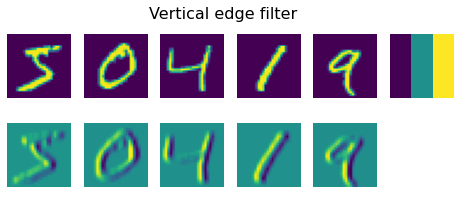

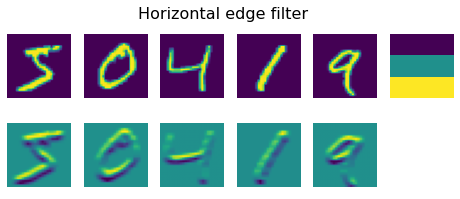

In [2]:
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')


First filter is called a **vertical edge filter**, and it is defined by the following matrix:


第一个过滤器称为**垂直边缘过滤器**，它由以下矩阵定义：

$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$
When this filter goes over relatively uniform pixel field, all values add up to 0. However, when it encounters a vertical edge in the image, high spike value is generated. That's why in the images above you can see vertical edges represented by high and low values, while horizontal edges are averaged out.

An opposite thing happens when we apply horizontal edge filter - horizontal lines are amplified, and vertical are averaged out.

> If we apply $3\times3$ filter to an image of size $28\times28$ - the size of the image will become $26\times26$, because the filter does not go over the image boundaries. In some cases, however, we may want to keep the size of the image the same, in which case image is padded with zeros on each side.

In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. However, in deep learning we construct networks that **learn** best convolutional filters to solve classification problem.

To do that, we introduce **convolutional layers**.

当此过滤器经过相对均匀的像素场时，所有值加起来为 0。但是，当它遇到图像中的垂直边缘时，会生成高尖峰值。 这就是为什么在上图中您可以看到由高值和低值表示的垂直边缘，而水平边缘被平均化了。

当我们应用水平边缘过滤器时会发生相反的事情——水平线被放大，垂直线被平均掉。

> 如果我们将 $3\times3$ 过滤器应用于大小为 $28\times28$ 的图像 - 图像的大小将变为 $26\times26$，因为过滤器不会越过图像边界。 然而，在某些情况下，我们可能希望保持图像的大小相同，在这种情况下，图像的每一侧都用零填充。

在经典的计算机视觉中，对图像应用多个过滤器以生成特征，然后机器学习算法使用这些特征来构建分类器。 然而，在深度学习中，我们构建了**学习**最佳卷积过滤器来解决分类问题的网络。

为此，我们引入了**卷积层**。

## Covolutional layers

Convolutional layers are defined using `nn.Conv2d` construction. We need to specify the following:
* `in_channels` - number of input channels. In our case we are dealing with a grayscale image, thus number of input channels is 1. Color image has 3 channels (RGB).
* `out_channels` - number of filters to use. We will use 9 different filters, which will give the network plenty of opportunities to explore which filters work best for our scenario.
* `kernel_size` is the size of the sliding window. Usually 3x3 or 5x5 filters are used. The choice of filter size is usually chosen by experiment, that is by trying out different filter sizes and comparing resulting accuracy.

Simplest CNN will contain one convolutional layer. Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 9x24x24 (the spatial size is smaller, because there are only 24 positions where a sliding interval of length 5 can fit into 28 pixels). Here the result of each filter is represented by a different channel in the image (thus the first dimension 9 corresponds to the number of filters).

After convolution, we flatten 9x24x24 tensor into one vector of size 5184, and then add linear layer, to produce 10 classes. We also use `relu` activation function in between layers. 

卷积层是使用“nn.Conv2d”结构定义的。 我们需要指定以下内容：
* `in_channels` - 输入通道的数量。 在我们的例子中，我们处理的是灰度图像，因此输入通道数为 1。彩色图像有 3 个通道 (RGB)。
* `out_channels` - 要使用的过滤器数量。 我们将使用 9 种不同的过滤器，这将为网络提供大量机会来探索哪些过滤器最适合我们的场景。
* `kernel_size` 是滑动窗口的大小。 通常使用 3x3 或 5x5 过滤器。 过滤器大小的选择通常通过实验来选择，即通过尝试不同的过滤器大小并比较结果精度。

最简单的 CNN 将包含一个卷积层。 给定输入大小 28x28，在应用九个 5x5 过滤器后，我们将得到一个 9x24x24 的张量（空间大小更小，因为只有 24 个位置长度为 5 的滑动间隔可以适合 28 个像素）。 这里每个过滤器的结果由图像中的不同通道表示（因此第一个维度 9 对应于过滤器的数量）。

卷积后，我们将 9x24x24 张量展平为一个大小为 5184 的向量，然后添加线性层，以产生 10 个类。 我们还在层与层之间使用 `relu` 激活函数。

In [2]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = OneConv()

summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

You can see that this network contains around 50k trainable parameters, compared to around 80k in fully-connected multi-layered networks. This allows us to achieve good results even on smaller datasets, because convolutional networks generalize much better.

> Note that the number of parameters of convolutional layer is quite small, and it *does not depend on the resolution of the image*! In our case, we were using 9 filters of dimension $5\times5$, thus the number of parameters is $9\times5\times5+9=234$. Even though we missed this in our discussion above, but convolutional filter also has bias. Most of the parameters of our network comes from the final `Dense` layer.

您可以看到该网络包含大约 50k 的可训练参数，而完全连接的多层网络中大约有 80k。 这使我们即使在较小的数据集上也能取得良好的结果，因为卷积网络的泛化能力要好得多。

> 请注意，卷积层的参数数量很少，而且*不依赖于图像的分辨率*！ 在我们的例子中，我们使用了 9 个维度为 $5\times5$ 的过滤器，因此参数数量为 $9\times5\times5+9=234$。 尽管我们在上面的讨论中忽略了这一点，但卷积滤波器也有偏差。 我们网络的大部分参数来自最后的`Dense`层。

Epoch  0, Train acc=0.951, Val acc=0.976, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.979, Val acc=0.976, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.984, Val acc=0.977, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.986, Val acc=0.973, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.988, Val acc=0.973, Train loss=0.000, Val loss=0.001


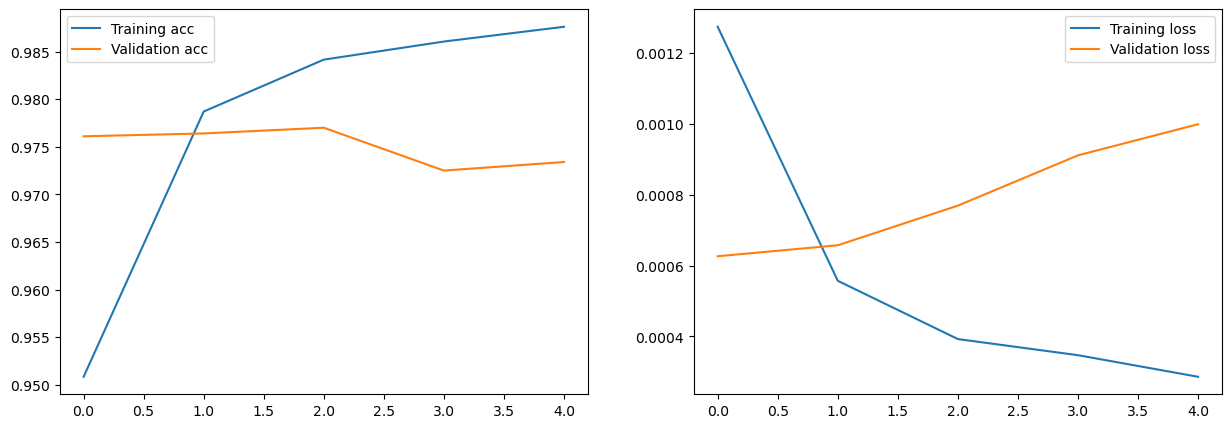

In [3]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

As you can see, we are able to achieve higher accuracy, and much faster, compared to the fully-connected networks from previous unit.

We can also visualize the weights of our trained convolutional layers, to try and make some more sense of what is going on:

如您所见，与之前单元的全连接网络相比，我们能够实现更高的精度和更快的速度。

我们还可以可视化我们训练的卷积层的权重，以尝试更清楚地了解正在发生的事情：

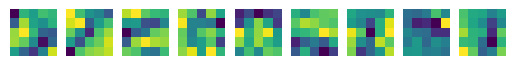

In [4]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

You can see that some of those filters look like they can recognize some oblique strokes, while others look pretty random. 

你可以看到其中一些过滤器看起来可以识别一些斜线，而其他过滤器看起来非常随机。

## Takeaway

Convolutional layer allows us to extract certain image patterns from the image, so that final classifier is based on top of those features. However, we can use the same approach of extracting patterns inside the feature space, by stacking another convolutional layer on top of the first one. We will learn about multi-layer convolutional networks in the next unit.


卷积层允许我们从图像中提取某些图像模式，以便最终分类器基于这些特征。 但是，我们可以使用相同的方法在特征空间内提取模式，方法是在第一个卷积层之上堆叠另一个卷积层。 我们将在下一个单元中学习多层卷积网络。